# Markowitz Portfolio Optimization

In [13]:
import os
from scipy.stats import norm
import pdfplumber
import re
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pylatex import Document, Section, Subsection, Tabular, Figure, NoEscape, Command, MiniPage
from scipy.stats import norm, probplot
import numpy as np
import scipy.optimize as sco
from scipy.optimize import minimize

In [17]:
def get_the_tickers():
    tickers = ["EUNL.DE",  #iShares Core MSCI World USD (Acc)
            "SXR8.DE", #iShares Core S&P 500 USD (Acc)
            "SXRV.DE", #iShares NASDAQ100 USD (Acc)
            "SXRY.DE", #iShares FTSE MIB EUR EUR (Acc)
            "EXS1.DE", #iShares Core DAX EUR (Acc)
            "AMES.DE", #Amundi IBEX 35 EUR (Acc)
            "GC40.DE", #Amundi CAC 40 EUR (Acc)
            "SXRW.DE", #iShares FTSE 100 GBP (Acc)
            "QDV5.DE", #iShares MSCI India USD (Acc)
            "PPFB.DE", #iShares Physical Gold USD (Acc)
            "IS0D.DE", #iShares Oil & Gas USD (Acc)
            ]

    ticker_descriptions = {
    "EUNL.DE": ("iShares Core MSCI World USD (Acc): ETF tracking the MSCI World Index — large and mid‑cap companies across 23 developed markets. Accumulating dividends, USD‑denominated."
    ),
    "SXR8.DE": ("iShares Core S&P 500 USD (Acc): ETF tracking the S&P 500 Index — 500 large‑cap U.S. companies. Accumulating dividends, USD‑denominated."
    ),
    "SXRV.DE": ("iShares NASDAQ 100 USD (Acc): ETF tracking the NASDAQ‑100 Index — 100 of the largest non‑financial U.S. and international companies listed on the Nasdaq. Accumulating dividends, USD‑denominated."
    ),
    "SXRY.DE": ("iShares FTSE MIB EUR (Acc): ETF tracking the FTSE MIB Index — 40 of the most liquid Italian stocks. Accumulating dividends, EUR‑denominated."
    ),
    "EXS1.DE": ("iShares Core DAX EUR (Acc): ETF tracking the DAX Index — 40 major German blue‑chip companies. Accumulating dividends, EUR‑denominated."
    ),
    "AMES.DE": ("Amundi IBEX 35 EUR (Acc): ETF tracking the IBEX 35 Index — 35 most liquid Spanish stocks. Accumulating dividends, EUR‑denominated."
    ),
    "GC40.DE": ("Amundi CAC 40 EUR (Acc): ETF tracking the CAC 40 Index — 40 largest French companies by market cap. Accumulating dividends, EUR‑denominated."
    ),
    "SXRW.DE": ("iShares FTSE 100 GBP (Acc): ETF tracking the FTSE 100 Index — 100 largest U.K. companies by market cap. Accumulating dividends, GBP‑denominated."
    ),
    "QDV5.DE": ("iShares MSCI India USD (Acc): ETF tracking the MSCI India Index — large and mid‑cap Indian companies. Accumulating dividends, USD‑denominated."
    ),
    "PPFB.DE": ("iShares Physical Gold USD (Acc): ETF physically backing gold bullion held in vaults. Provides pure gold price exposure. Accumulating (no dividend). USD‑denominated."
    ),
    "IS0D.DE": ("iShares Oil & Gas USD (Acc): ETF tracking the STOXX Global Oil & Gas Index — major oil and gas companies. Accumulating dividends, USD‑denominated."
    ),
}
    return tickers, ticker_descriptions

def get_asset_data(tickers, start_date="2015-01-01", end_date="2025-01-01"):
    """
    Downloads the "Adj Closes" of selected tickers in the period [start_date - end_date] from Yahoo Finance. Returns a DataFrame with columns = Ticker and indexes = Date.
    """
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
    price_data = data['Adj Close']

    print(f"Fetching data from {start_date} to {end_date}")
    return price_data

def compute_returns(data):
    """
    Computes daily returns. Returns a DataFrame with daily percentage returns, removing any NaN values.
    """
    # Calculate the percentage return and remove NaN values
    returns = data.pct_change(fill_method=None).dropna()
    return returns


def analyze_tickers(tickers, ticker_descriptions, returns_df, window=30):
    img_dir = 'ticker_images'
    os.makedirs(img_dir, exist_ok=True)

    # Set up LaTeX document
    geometry_options = {"top": "3.5cm",
                        "left": "3cm",
                        "right": "3cm",
                        "bottom": "3.5cm"}
    doc = Document('Complete_Ticker_Analysis', geometry_options=geometry_options)
    doc.preamble.append(NoEscape(r'''
        \usepackage{graphicx}
        \usepackage[sc]{mathpazo}
        \linespread{1.05}
        \usepackage{microtype}
        \usepackage{fancyhdr}
        \pagestyle{fancy}
    '''))


    doc.preamble.append(Command('title', 'Ticker Analysis'))
    doc.preamble.append(Command('author', NoEscape('')))
    doc.preamble.append(Command('date', NoEscape('')))
    doc.append(NoEscape(r'\maketitle'))

    # Create each ticker as its own Section
    for ticker in tickers:
        returns = returns_df[ticker].dropna()

        with doc.create(Section(f'Analysis of Ticker {ticker}', numbering=False)):
            # ETF description
            doc.append(ticker_descriptions[ticker])

            # Figure 1: Daily Returns
            plt.figure(figsize=(8, 4))
            plt.plot(returns.index, returns, label="Daily Returns")
            plt.xlabel("Date")
            plt.ylabel("Return")
            plt.title(f"Daily Returns for {ticker}")
            plt.legend()
            plt.grid(True)
            img_returns = os.path.join(img_dir, f'{ticker}_daily_returns.png')
            plt.savefig(img_returns, bbox_inches='tight')
            plt.close()
            img_returns = img_returns.replace('\\', '/')

            # Figure 2: Equity Curve
            equity_curve = (1 + returns).cumprod()
            plt.figure(figsize=(8, 4))
            plt.plot(equity_curve.index, equity_curve, label="Equity Curve")
            plt.xlabel("Date")
            plt.ylabel("Normalized Value")
            plt.title(f"Equity Curve for {ticker}")
            plt.legend()
            plt.grid(True)
            img_equity = os.path.join(img_dir, f'{ticker}_equity_curve.png')
            plt.savefig(img_equity, bbox_inches='tight')
            plt.close()
            img_equity = img_equity.replace('\\', '/')

            # Insert two-panel figure
            with doc.create(Figure(position='htbp')):
                for img in [img_returns, img_equity]:
                    with doc.create(MiniPage(width=NoEscape('0.49\\textwidth'))):
                        doc.append(NoEscape(f"\\includegraphics[width=\\linewidth]{{{img}}}"))

            # Figure 3: Return Distribution
            plt.figure(figsize=(8, 4))
            n, bins, _ = plt.hist(returns, bins=50, density=True, alpha=0.6, label="Histogram")
            mu, sigma = norm.fit(returns)
            x = np.linspace(min(bins), max(bins), 100)
            pdf = norm.pdf(x, mu, sigma)
            plt.plot(x, pdf, 'r', linewidth=2, label=f'Normal fit (μ={mu:.4f}, σ={sigma:.4f})')
            plt.xlabel("Return")
            plt.ylabel("Density")
            plt.title(f"Distribution of Returns for {ticker}")
            plt.legend()
            plt.grid(True)
            img_dist = os.path.join(img_dir, f'{ticker}_return_distribution.png')
            plt.savefig(img_dist, bbox_inches='tight')
            plt.close()
            img_dist = img_dist.replace('\\', '/')

            # Figure 4: QQ Plot
            plt.figure(figsize=(8, 4))
            probplot(returns, dist="norm", plot=plt)
            plt.title(f"QQ Plot of Returns for {ticker}")
            plt.grid(True)
            img_qq = os.path.join(img_dir, f'{ticker}_qq_plot.png')
            plt.savefig(img_qq, bbox_inches='tight')
            plt.close()
            img_qq = img_qq.replace('\\', '/')

            # Insert three-panel figure
            with doc.create(Figure(position='htbp')):
                for img in [img_dist, img_qq]:
                    with doc.create(MiniPage(width=NoEscape('0.49\\textwidth'))):
                        doc.append(NoEscape(f"\\includegraphics[width=\\linewidth]{{{img}}}"))

            # Figure 5: Rolling Mean and Variance
            rolling_mean = returns.rolling(window=window).mean()
            rolling_var = returns.rolling(window=window).var()

            fig, ax1 = plt.subplots(figsize=(8, 4))
            ax1.plot(rolling_mean.index, rolling_mean, label="Rolling Mean")
            ax1.set_xlabel("Date")
            ax1.set_ylabel("Rolling Mean")
            ax1.legend(loc='upper left')
            ax1.grid(True)

            ax2 = ax1.twinx()
            ax2.plot(rolling_var.index, rolling_var, label="Rolling Variance", color='orange')
            ax2.set_ylabel("Rolling Variance")
            ax2.legend(loc='upper right')

            plt.title(f"Rolling Statistics for {ticker} (window={window})")
            img_roll = os.path.join(img_dir, f'{ticker}_rolling_stats.png')
            plt.savefig(img_roll, bbox_inches='tight')
            plt.close()
            img_roll = img_roll.replace('\\', '/')

            # Insert last  figure
            with doc.create(Figure(position='htbp')):
                for img in [img_roll]:
                    with doc.create(MiniPage(width=NoEscape('0.49\\textwidth'))):
                        doc.append(NoEscape(f"\\includegraphics[width=\\linewidth]{{{img}}}"))

            doc.append(NoEscape(r'\newpage'))


    # Generate PDF (keeps .tex for inspection)
    doc.generate_pdf(clean_tex=False, compiler='pdflatex')


def expected_return(weights, returns):
    return np.sum(returns.mean()*weights)*252

def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def min_variance_portfolio(mu, cov):
    """
    Computes the minimum variance portfolio (long-only) constrained to weights >= 0, sum(w)=1.
    """
    n = len(mu)
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    init_guess = np.array(n * [1.0/n])

    result = sco.minimize(lambda w: np.dot(w, np.dot(cov, w)),
                          init_guess,
                          method='SLSQP',
                          bounds=bounds,
                          constraints=cons)
    return result.x

def max_sharpe_portfolio(mu, cov, risk_free_rate):
    """
    Computes the optimal portfolio weights (tangency portfolio) in the presence of a risk-free rate.
    """
    def neg_sharpe_ratio(weights, mu, cov_matrix, risk_free_rate):
        return -sharpe_ratio(weights, mu, cov_matrix, risk_free_rate)

    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    bounds = [(0, 0.4) for _ in range(len(mu))]
    initial_weights = np.array([1/len(mu)]*len(mu))

    optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(mu, cov, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
    return optimized_results.x

def allocate_capital(rf_rate, r_tangent, sigma_tangent, capital, target_return=None, target_risk=None):
    if abs(r_tangent - rf_rate) < 1e-9:
        raise ValueError("Il portafoglio tangente ha rendimento identico al risk-free, impossibile calcolare la leva.")

    if target_return is None and target_risk is None:
        raise ValueError("Devi specificare almeno target_return o target_risk.")

    if target_return is not None and target_risk is not None:
        raise ValueError("Puoi specificare o target_return o target_risk.")
    elif target_return is not None:
        alpha = (target_return - rf_rate) / (r_tangent - rf_rate)
    else:
        alpha = target_risk / sigma_tangent

    # Forza alpha a essere compreso tra 0 e 1
    alpha = max(0, min(1, alpha))

    capital_risky = alpha * capital
    capital_rf = (1 - alpha) * capital

    return alpha, capital_risky, capital_rf

def allocate_to_euros(weights, capital):
    """
    Transforms weights (between 0 and 1) into integer amounts (rounded to the euro) whose sum is exactly 'capital'.
    """
    capital_int = int(round(capital))
    raw_values = weights * capital_int
    floored_values = np.floor(raw_values).astype(int)
    leftover = capital_int - floored_values.sum()
    fractional_part = raw_values - floored_values
    sorted_idx = np.argsort(-fractional_part)
    i = 0
    while leftover > 0 and i < len(sorted_idx):
        floored_values[sorted_idx[i]] += 1
        leftover -= 1
        i += 1
    return floored_values

def generate_random_portfolios(mu, cov, num_portfolios=10000):
    """
    Generates random portfolios (long-only) to illustrate the frontier. Returns an array with rows = [risk, return, Sharpe].
    """
    n = len(mu)
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = abs(np.random.random(n))
        weights /= np.sum(weights)
        port_return = np.dot(weights, mu)
        port_risk = np.sqrt(np.dot(weights, np.dot(cov, weights)))
        sharpe = (port_return - 0.025) / port_risk if port_risk != 0 else 0
        results[0, i] = port_risk
        results[1, i] = port_return
        results[2, i] = sharpe
    return results

In [ ]:
###############################################################################
#                           FUNZIONI DI PLOTTAGGIO                            #
###############################################################################

def plot_efficient_frontier(mu, cov, w_min, w_opt, random_results, overall_risk, overall_return):
    """
    Plotta i portafogli casuali, il portafoglio min var (X), max Sharpe e il portafoglio complessivo (con risk-free).
    """
    plt.figure(figsize=(20, 12))

    # Portafogli casuali
    plt.scatter(random_results[0, :], random_results[1, :],
                c=random_results[2, :], cmap='viridis', alpha=0.5)
    plt.xlim(0, 0.3)
    plt.ylim(0, 0.3)
    plt.colorbar(label='Sharpe Ratio')

    # Portafoglio max Sharpe
    risk_opt = np.sqrt(w_opt.T.dot(cov).dot(w_opt))
    ret_opt = np.dot(w_opt, mu)
    plt.scatter(risk_opt, ret_opt, marker='*', color='r', s=500,
                label='Optimal (Max Sharpe) Portfolio')

    # Portafoglio min var
    risk_min = np.sqrt(w_min.T.dot(cov).dot(w_min))
    ret_min = np.dot(w_min, mu)
    plt.scatter(risk_min, ret_min, marker='X', color='b', s=200,
                label='Minimum Variance Portfolio')

    # Portafoglio complessivo (risky + risk-free)
    plt.scatter(overall_risk, overall_return, marker='D', color='orange', s=300, label='Overall Portfolio (Risk-Free + Risky)')

    plt.title("Efficient Frontier e Tradeoff Rischio-Rendimento")
    plt.xlabel("Rischio Annualizzato (Volatilità)")
    plt.ylabel("Rendimento Annualizzato")
    plt.legend()
    plt.show()

def plot_portfolio_distribution(mu, sigma):
    """
    Plotta la distribuzione dei returns del portafoglio assumendo una distribuzione normale.
    """
    # Crea una griglia per l'asse x
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    y = norm.pdf(x, loc=mu, scale=sigma)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y)
    plt.xlabel('Rendimento del Portafoglio')
    plt.ylabel('Densità di Probabilità')
    plt.title('Distribuzione dei returns del Portafoglio')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# MAIN FUNCTION #

def main(capital, target_return=None, target_risk=None, risk_free_rate=0.025, data=None, all_tickers=None):
    if data is None:
        # Scarica i dati e crea un DataFrame
        all_tickers, ticker_descriptions = get_the_tickers()
        data = get_asset_data(all_tickers)

    # Pulizia: rimuove ticker e date completamente NaN
    data.dropna(axis=1, how='all', inplace=True)  # rimuove i ticker senza dati
    data.dropna(axis=0, how='all', inplace=True)  # rimuove le date senza dati

    returns = compute_returns(data)

    # Analizza i ticker
    analyze_tickers(all_tickers, ticker_descriptions, returns, window=30)

    annualized_return = returns.mean() * 252
    annualized_cov = returns.cov() * 252

    # Calcola i portafogli MinVar e MaxSharpe
    w_min = min_variance_portfolio(annualized_return, annualized_cov)
    w_opt = max_sharpe_portfolio(annualized_return, annualized_cov, risk_free_rate)

    # Calcola expected return e variance per il portafoglio Max Sharpe
    exp_return_opt = expected_return(w_opt, returns)
    std_dev_opt = standard_deviation(w_opt, annualized_cov)
    print(f"Portafoglio Max Sharpe: \nExpected Return = {exp_return_opt:.2%}, \nVolatilità = {std_dev_opt:.2%}")

    # Allocazione del capitale tra risky asset e risk-free
    alpha, capital_risky, capital_rf = allocate_capital(risk_free_rate, exp_return_opt, std_dev_opt, capital, target_return, target_risk)
    capital_risky = allocate_to_euros(w_opt, capital_risky)

    # Calcola il rendimento e la volatilità del portafoglio complessivo
    overall_return = alpha * exp_return_opt + (1 - alpha) * risk_free_rate
    overall_risk = alpha * std_dev_opt
    print(f"Portafoglio Complessivo (Risk-Free + Risky):\nExpected Return = {overall_return:.2%}, \nVolatilità = {overall_risk:.2%}")

    # Creazione del DataFrame con i risultati risky e risk-free
    df_portfolio = pd.DataFrame({
        "ETF": data.columns.to_list(),
        "Allocazione MaxSharpe (EUR)": capital_risky
    })
    df_portfolio = df_portfolio[df_portfolio["Allocazione MaxSharpe (EUR)"] > 0]
    df_risk_free = pd.DataFrame({
        "ETF": ["Risk-Free"],
        "Allocazione MaxSharpe (EUR)": [int(round(capital_rf))]
    })
    df_portfolio = pd.concat([df_portfolio, df_risk_free], ignore_index=True)
    df_portfolio.to_excel("portfolio.xlsx", index=False)

    # Genera portafogli casuali e plotta la frontiera
    random_results = generate_random_portfolios(annualized_return, annualized_cov)
    plot_efficient_frontier(annualized_return, annualized_cov, w_min, w_opt, random_results, overall_risk, overall_return)

    # Plotta la distribuzione del portafoglio
    plot_portfolio_distribution(overall_return, overall_risk)

    # Calcolo dei VaR in termini di perdita assoluta (EUR)
    from scipy.stats import norm
    q1 = norm.ppf(0.01, loc=overall_return, scale=overall_risk)
    q5 = norm.ppf(0.05, loc=overall_return, scale=overall_risk)
    # Se il quantile è negativo, il VaR è la perdita attesa (altrimenti zero)
    VaR_1 = -q1 if q1 < 0 else 0
    VaR_5 = -q5 if q5 < 0 else 0
    VaR_1_eur = capital * VaR_1
    VaR_5_eur = capital * VaR_5
    print(f"VaR al 1%: {VaR_1_eur:.2f} EUR")
    print(f"VaR al 5%: {VaR_5_eur:.2f} EUR")

    return df_portfolio

[*********************100%***********************]  11 of 11 completed


Fetching data from 2015-01-01 to 2025-01-01
Portafoglio Max Sharpe: 
Expected Return = 16.27%, 
Volatilità = 9.01%
Portafoglio Complessivo (Risk-Free + Risky):
Expected Return = 16.27%, 
Volatilità = 9.01%


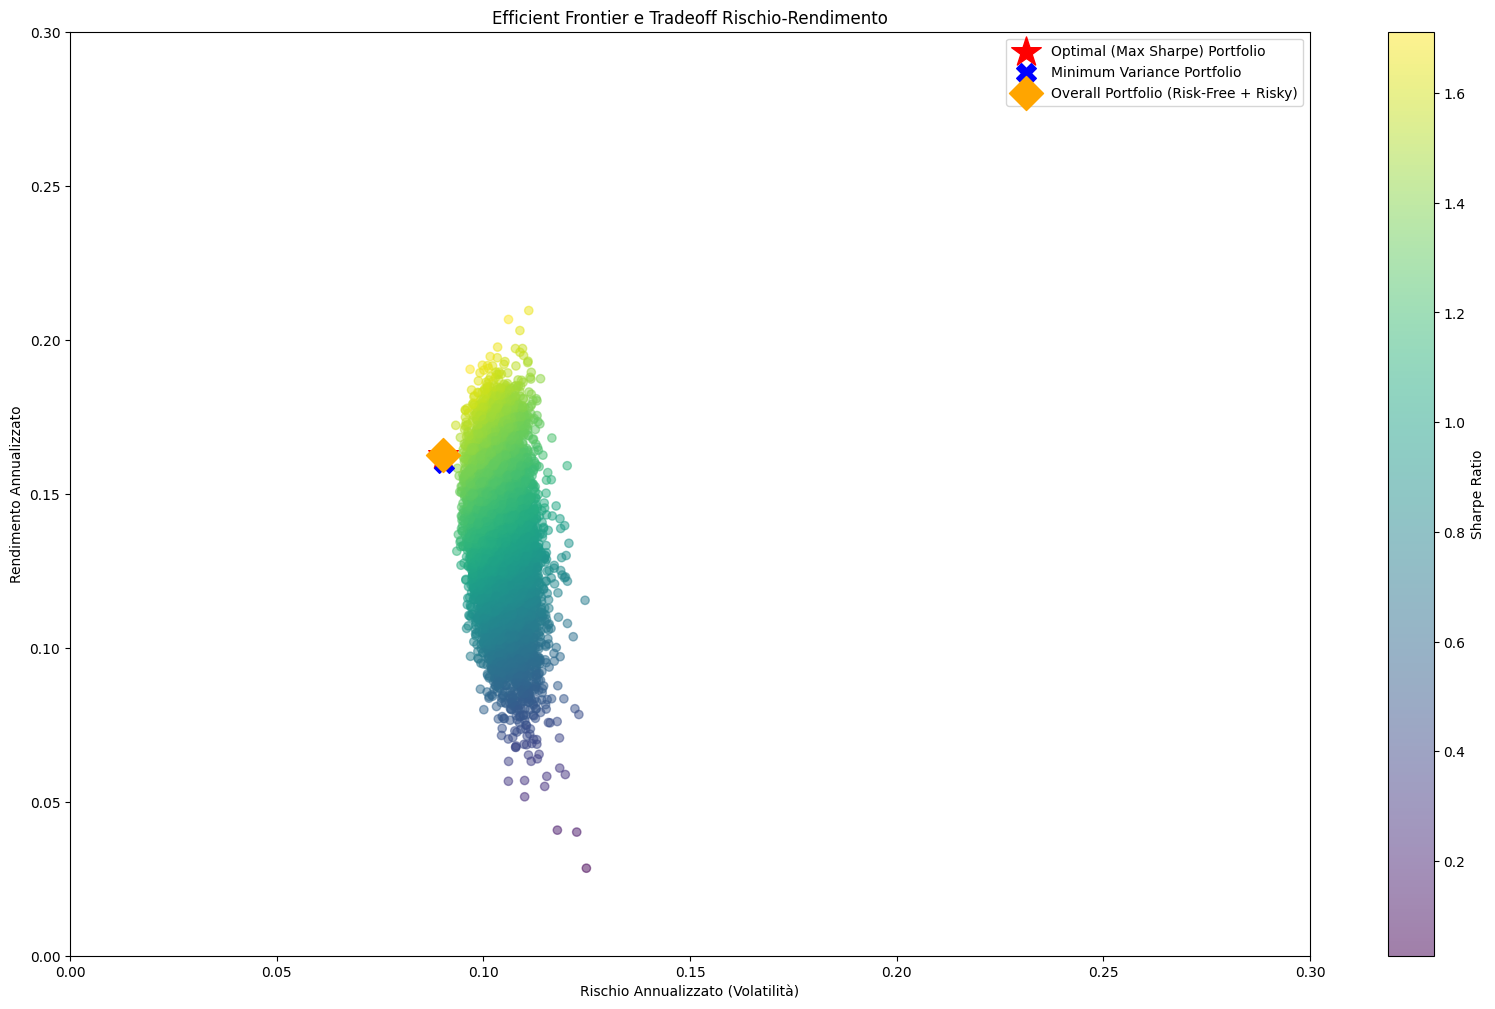

/tmp/ipython-input-1760673340.py:341: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


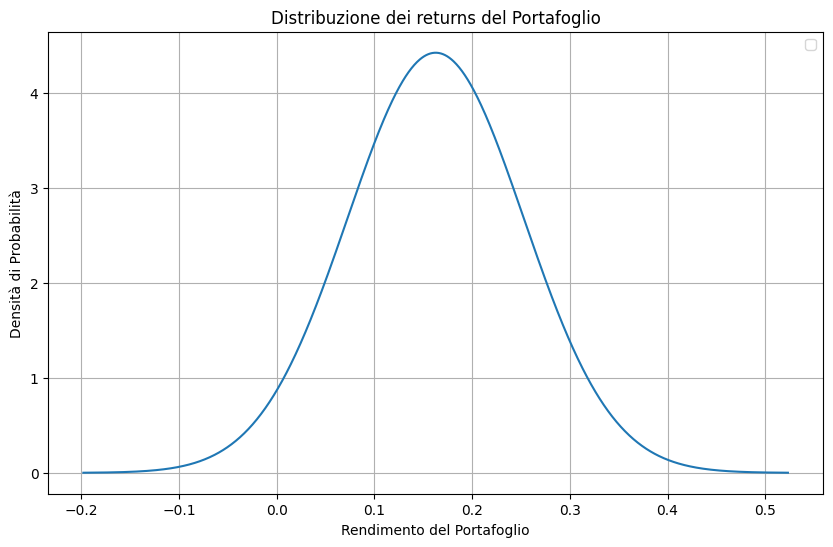

VaR al 1%: 47.00 EUR
VaR al 5%: 0.00 EUR


,ETF,Allocazione MaxSharpe (EUR)
0,AMES.DE,151
1,GC40.DE,79
2,PPFB.DE,273
3,QDV5.DE,74
4,SXR8.DE,211
5,SXRW.DE,212
6,Risk-Free,0


In [15]:
main(1000, target_return=1.1)